# **Lucas-Kanade optical flow algorithm**

In [ ]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

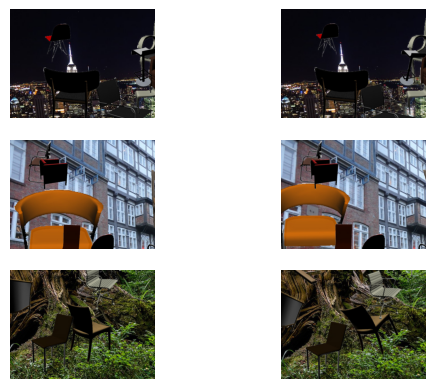

In [331]:
D = []
img_paths = []
lst = []
img_paths.append(["/content/drive/MyDrive/data/Data/D1/img1.jpg","/content/drive/MyDrive/data/Data/D1/img2.jpg"])
img_paths.append(["/content/drive/MyDrive/data/Data/D2/img1.jpg","/content/drive/MyDrive/data/Data/D2/img2.jpg"])
img_paths.append(["/content/drive/MyDrive/data/Data/D3/img1.jpg","/content/drive/MyDrive/data/Data/D3/img2.jpg"])

grayscale_transform = transforms.Grayscale()
def normalize_image(image):
    return image.astype(np.float32) / 255.0

for i in range(3):
  for j in range(2):
    image = Image.open(img_paths[i][j]).convert('RGB')
    image = normalize_image(np.array(image))
    lst.append(np.array(image))

  D.append(lst)
  lst = []

fig, axs = plt.subplots(3, 2)
for i in range(3):
    for j in range(2):
        axs[i, j].imshow(D[i][j])
        axs[i, j].axis('off')
plt.show()


In [332]:
import numpy as np

def convolve2d(image, kernel):
    kernel_height, kernel_width = kernel.shape
    image_height, image_width, channels = image.shape
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width), (0, 0)), mode='constant')
    output = np.zeros_like(image)

    for i in range(image_height):
        for j in range(image_width):
            for c in range(channels):
                region = padded_image[i:i+kernel_height, j:j+kernel_width, c]
                output[i, j, c] = np.sum(region * kernel)

    return output

def compute_gradients(image1, image2):

    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    Ix1 = convolve2d(image1, sobel_x)
    Iy1 = convolve2d(image1, sobel_y)

    Ix2 = convolve2d(image2, sobel_x)
    Iy2 = convolve2d(image2, sobel_y)

    Ix = Ix1 + Ix2
    Iy = Iy1 + Iy2

    It = image2 - image1

    return Ix, Iy, It

In [333]:
Ix_list = []
Iy_list = []
It_list = []
for i in range(3):
  Ix,Iy,It = compute_gradients(D[i][0],D[i][1])
  Ix_list.append(Ix)
  Iy_list.append(Iy)
  It_list.append(It)

In [334]:
def lucas_kanade_optical_flow(Ix, Iy, It, window_size):
    half_window = window_size // 2
    u = np.zeros_like(Ix[:,:,0])
    v = np.zeros_like(Ix[:,:,0])

    for i in range(half_window, Ix.shape[0] - half_window):
        for j in range(half_window, Ix.shape[1] - half_window):

            Ix_window = (np.transpose(Ix[i - half_window : i + half_window + 1, j - half_window : j + half_window + 1,:],axes=(1, 2, 0))).reshape(-1).flatten()
            Iy_window = (np.transpose(Iy[i - half_window : i + half_window + 1, j - half_window : j + half_window + 1,:],axes=(1, 2, 0))).reshape(-1).flatten()
            It_window = (np.transpose(It[i - half_window : i + half_window + 1, j - half_window : j + half_window + 1,:],axes=(1, 2, 0))).reshape(-1).flatten()

            A = np.vstack((Ix_window, Iy_window)).T
            b = -It_window.reshape((-1, 1))

            if np.linalg.matrix_rank(A) == 2:

                ATA_inv = np.linalg.inv(np.dot(A.T, A))
                flow = np.dot(np.dot(ATA_inv, A.T), b)
                u[i, j] = flow.item(0)
                v[i, j] = flow.item(1)

    return u, v


In [335]:
gt1 = "/content/drive/MyDrive/data/Data/D1/GT1.npy"
gt2 = "/content/drive/MyDrive/data/Data/D2/GT2.npy"
gt3 = "/content/drive/MyDrive/data/Data/D3/GT3.npy"

gt_paths = [gt1,gt2,gt3]
gts = []

for i in range(3):
  data = np.load(gt_paths[i])
  gts.append(data)

In [339]:
window_sizes = [3,5, 15]
u_list =[]
v_list = []
res_list =[]

for i in range(3):
  print(f"For image_{i}:")
  for window_size in window_sizes:
    u, v = lucas_kanade_optical_flow(Ix_list[i], Iy_list[i], It_list[i], window_size)
    res = np.sqrt(u**2 + v**2)
    res_list.append(res)
    error =np.mean(np.sqrt((res- gts[i])**2))
    print(f"Mean squared error for window size {window_size}x{window_size}: {error}")

For image_0:
Mean squared error for window size 3x3: 4.179466247558594
Mean squared error for window size 5x5: 4.205702304840088
Mean squared error for window size 15x15: 4.222719669342041
For image_1:
Mean squared error for window size 3x3: 15.950691223144531
Mean squared error for window size 5x5: 15.999549865722656
Mean squared error for window size 15x15: 16.097078323364258
For image_2:
Mean squared error for window size 3x3: 27.937044143676758
Mean squared error for window size 5x5: 28.033048629760742
Mean squared error for window size 15x15: 28.133102416992188


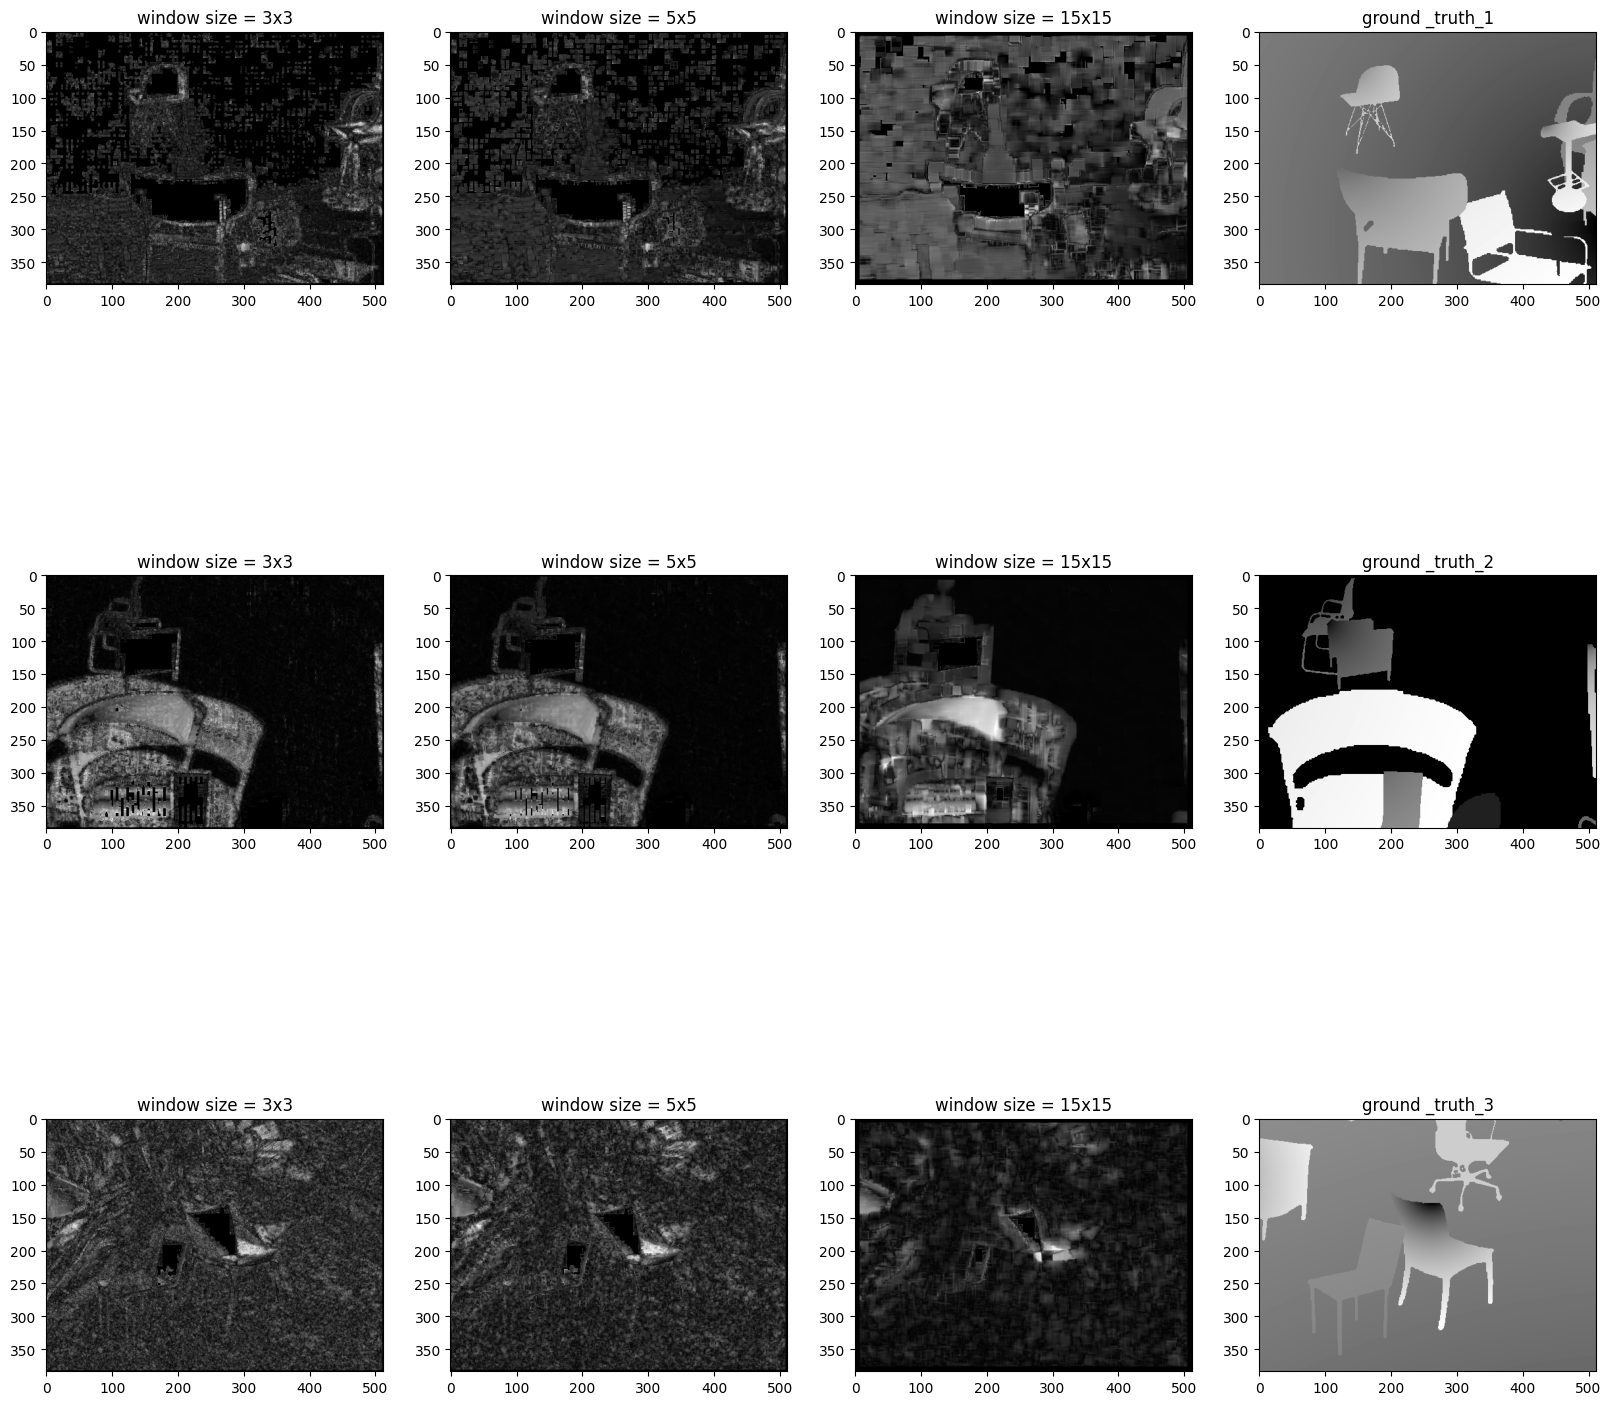

In [353]:
fig, axes = plt.subplots(3, 4, figsize=(20,20))  # Create a 3x2 grid of subplots

for i in range(3):
    # Plot res_list image on the left subplot
    axes[i, 0].imshow(np.log(0.1+res_list[3*i]), cmap='gray')
    axes[i, 0].set_title('window size = 3x3')

    axes[i, 1].imshow(np.log(0.1+res_list[3*i+1]), cmap='gray')
    axes[i, 1].set_title('window size = 5x5')

    axes[i, 2].imshow(np.log(0.1+res_list[3*i+2]), cmap='gray')
    axes[i, 2].set_title('window size = 15x15')

    # Plot gts image on the right subplot
    axes[i, 3].imshow(np.log(0.1+gts[i]), cmap='gray')
    axes[i, 3].set_title('ground _truth_{}'.format(i+1))

# Show plot
plt.show()
